In [1]:
%matplotlib inline
import math
import os 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from pandas import ExcelWriter
import pickle

In [2]:
def load_object(filename):
    with open(filename, 'rb') as fid:
        file = pickle.load(fid)
    return file

In [9]:
#load the codes
Qian2016codes = load_object('models/Qian2016codes.pkl')
Qian2018codes = load_object('models/Qian2018codes.pkl')
QianU2019codes = load_object('models/QianU2019codes.pkl')
QianR2019codes = load_object('models/QianR2019codes.pkl')
Sourcecodes = load_object('models/Sourcecodes.pkl')

#Load the DFs
Qian2016DF, Qian2016prob, Qian2016keys = load_object('models/Qian2016DF.pkl')
Qian2018DF, Qian2018prob, Qian2018keys = load_object('models/Qian2018DF.pkl')
QianU2019DF, QianU2019prob, QianU2019keys = load_object('models/QianU2019DF.pkl')
QianR2019DF, QianR2019prob, QianR2019keys = load_object('models/QianR2019DF.pkl')
SourceDF, Sourceprob, Sourcekeys = load_object('models/SourceDF.pkl')

clustersdata = [Qian2016DF, Qian2018DF, QianU2019DF, QianR2019DF, SourceDF]
airkeys = [Qian2016keys, Qian2018keys, QianU2019keys, QianR2019keys, Sourcekeys]

# Percentage of particles based on max probability

In [10]:
def plotdf(combineddf, keys):    
    #mask probability
    combineddf = combineddf.iloc[:,:-1]
    particlecount = pd.DataFrame()
    for sample in combineddf['labels'].unique():
        df = combineddf[combineddf['labels'] == sample]
        combinedlist = []
        for cluster in df['clusters'].unique():
            combinedlist.append([cluster, df[df['clusters'] == cluster]['labels'].count()])
        particlecount = pd.concat([particlecount, pd.DataFrame(combinedlist).set_index(0)
    ], axis = 1)

    particlecount.columns = combineddf['labels'].unique()

    #Percentage
    for i in particlecount.columns:
        particlecount[i] = particlecount[i]/particlecount[i].sum()

    plotdf = pd.melt(particlecount.loc[particlecount.max(axis=1).sort_values(ascending = False).index, keys].reset_index(), id_vars = 0)
    return plotdf

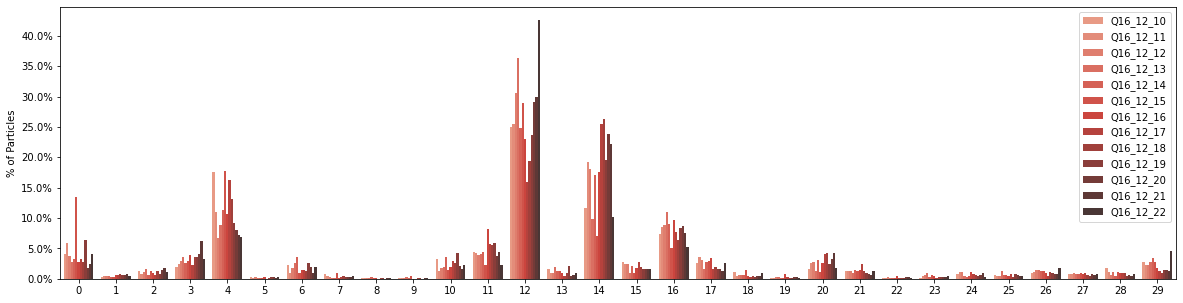

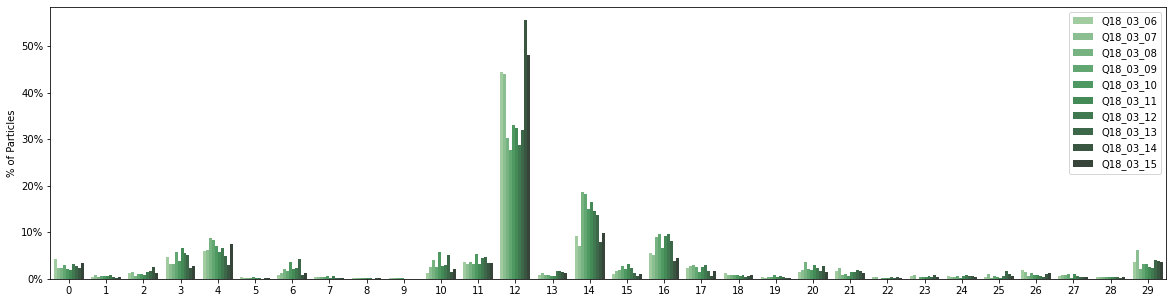

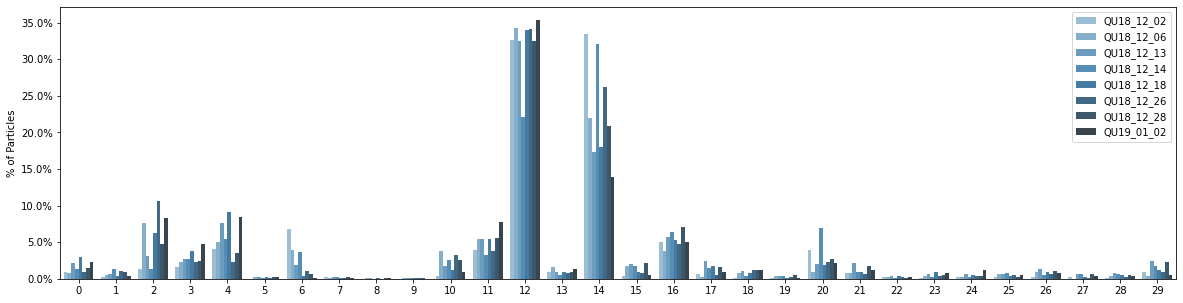

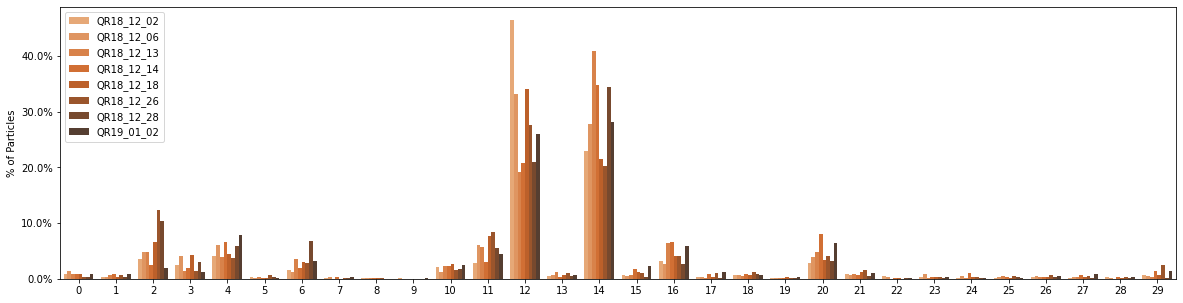

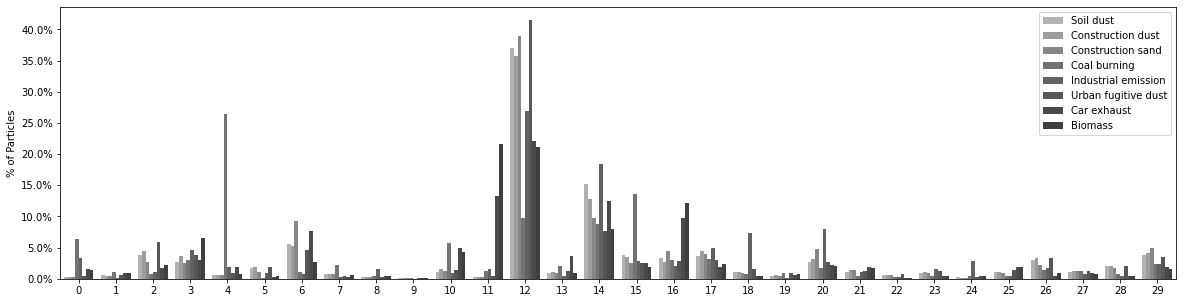

In [15]:
#percentage of particles in each component for each source
clusterplotdata = [plotdf(i,j) for i,j in zip(clustersdata, airkeys)]

for i in clusterplotdata:
    i['value'] = i['value']*100
    
import matplotlib.ticker as mtick
colors = ['Reds_d', 'Greens_d', 'Blues_d', 'Oranges_d', 'Greys_d']
for i,j in zip(clusterplotdata, colors):
    fig = plt.figure(figsize = (20,5))
    ax = sns.barplot(x= 0, y = 'value', data = i, hue = 'variable', palette = j)
    ax.set_ylabel('% of Particles')
    ax.set_xlabel('')
    ax.legend(loc = 'best')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [16]:
#returns aggregate particles of a dataset
def aggregate_particles(data, element1 = None):
    total = []
    #go through each row
    for i in data.itertuples():
        labels = []
        #in that row, go through each element
        for j in range(1, len(i)):
            #if there is some value
            if i[j] > 0:
                #append the element into the labels list
                labels.append(data.columns[j - 1])
                #if there is no elements
                if labels[-1] == None:
                    print('ERROR')
        #if there are some elements in the labels list
        if labels != []:
            #append it to the total list
            total.append(labels)
    #make an array of this
    total = np.array(total, dtype = 'object')
    #only find the unique labels
    uniquelist = np.unique(total)
    
    
    #if element1 is there, focus on that one element
    if element1 != None:
        uniquelist = uniquelist[[element1 in i for i in uniquelist]]
        
    uniquelist1 = []
    #for each unique label
    for i in uniquelist:
        #join them together with a + sign
        uniquelist1.append('+'.join(i))
    totalvalue = []
    # for each unique label
    for i in uniquelist:
        value = 0
        # for each label in total
        for j in total:
            if i == j:
                #count how many there are
                value = value + 1
        totalvalue.append(value)

    finaldf = pd.DataFrame(totalvalue, uniquelist1, columns = ['Value']).sort_values('Value', ascending = False)
    return finaldf

# Example graph of a Source and their aggregate particles

<ipython-input-22-3d4fd81c8506>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (20,5))


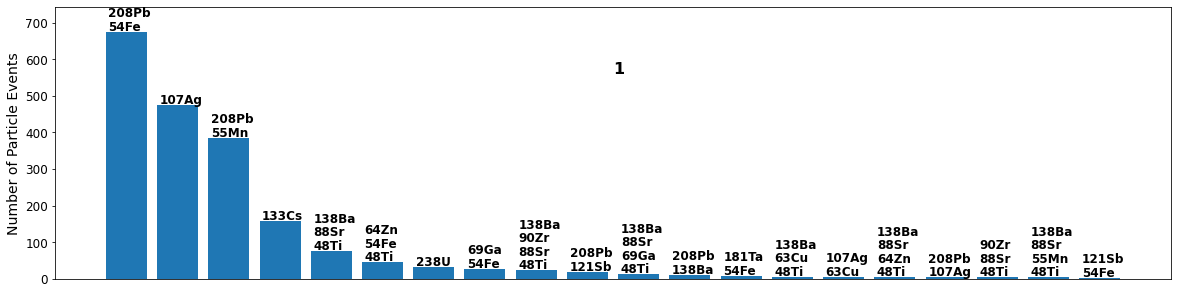

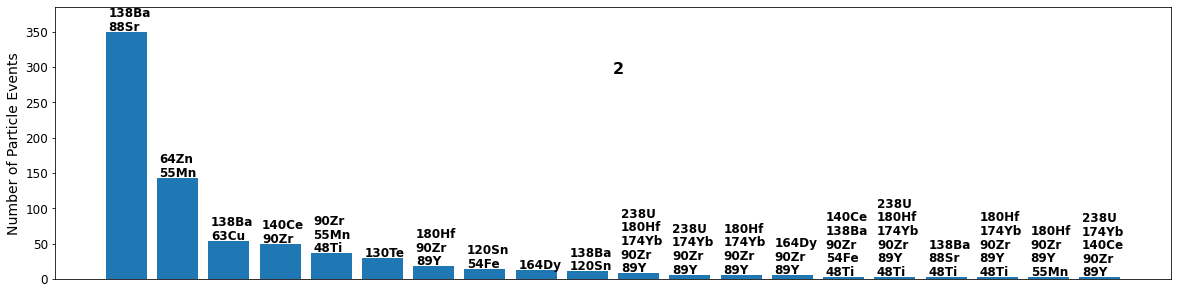

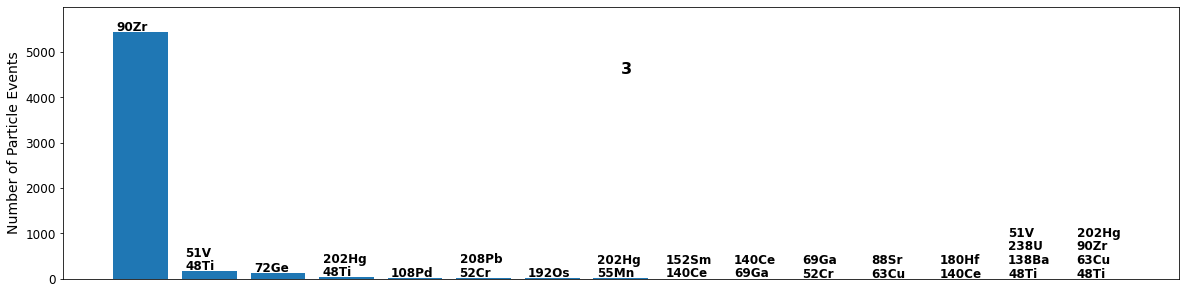

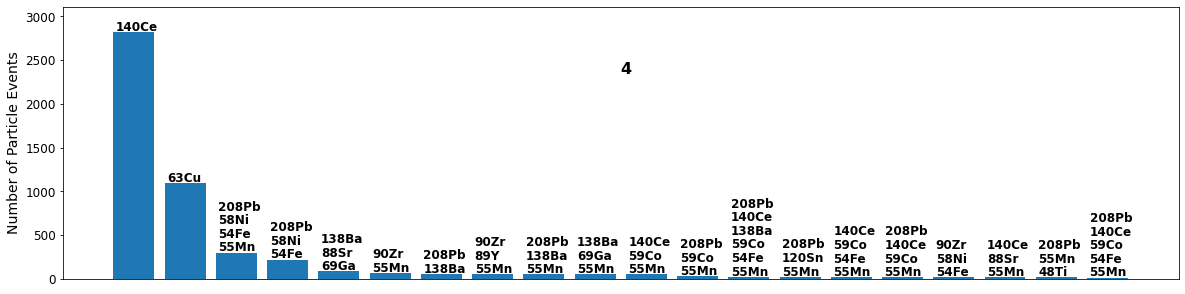

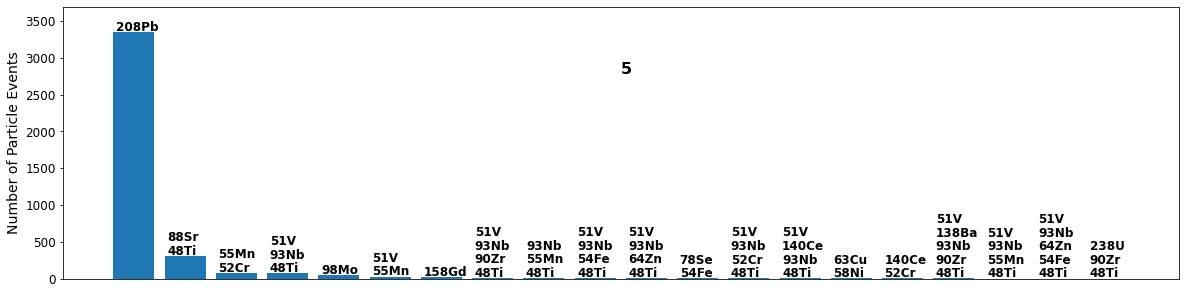

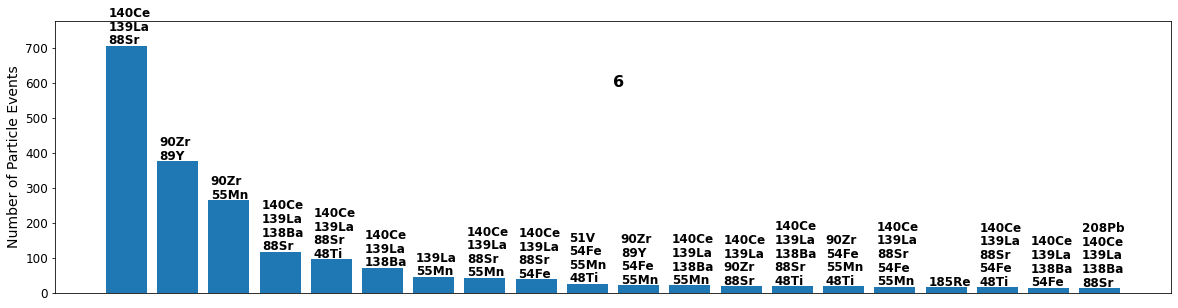

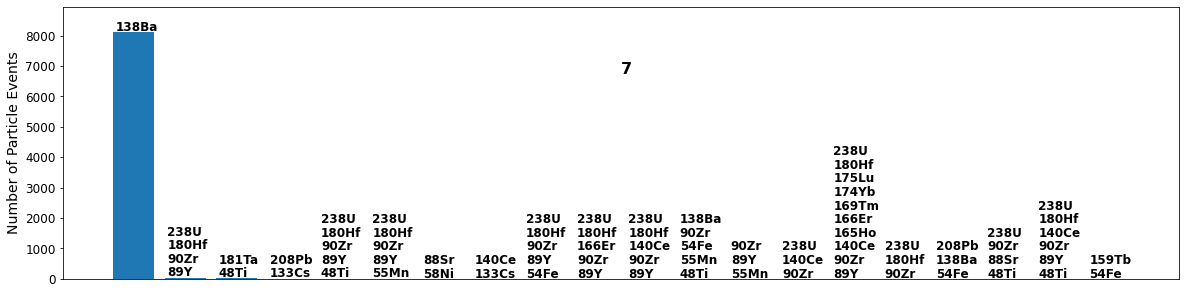

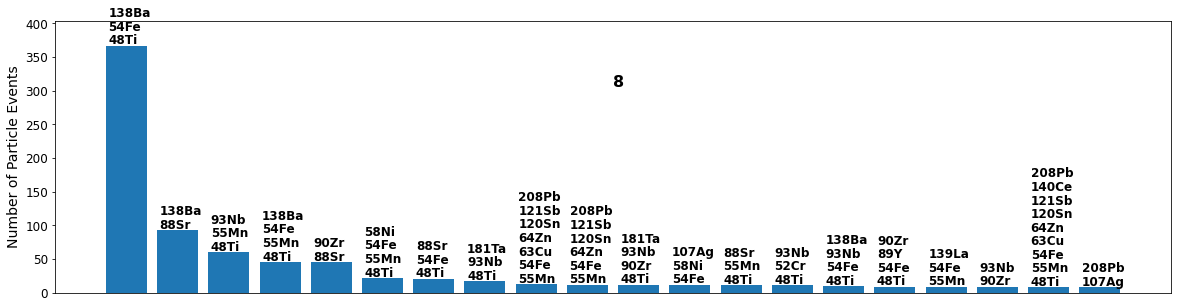

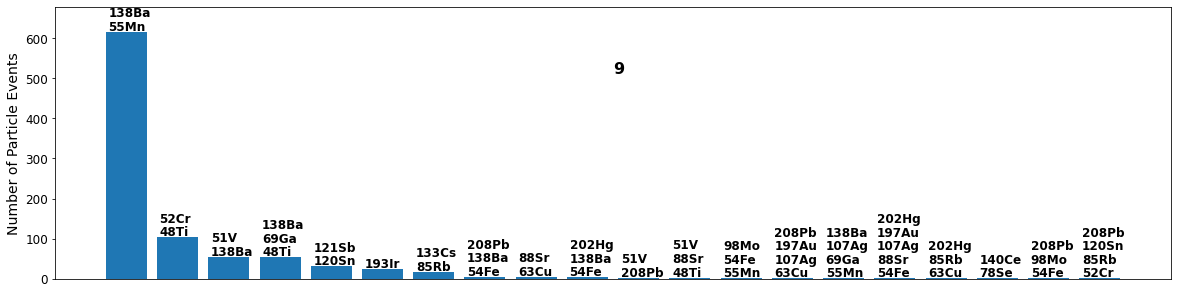

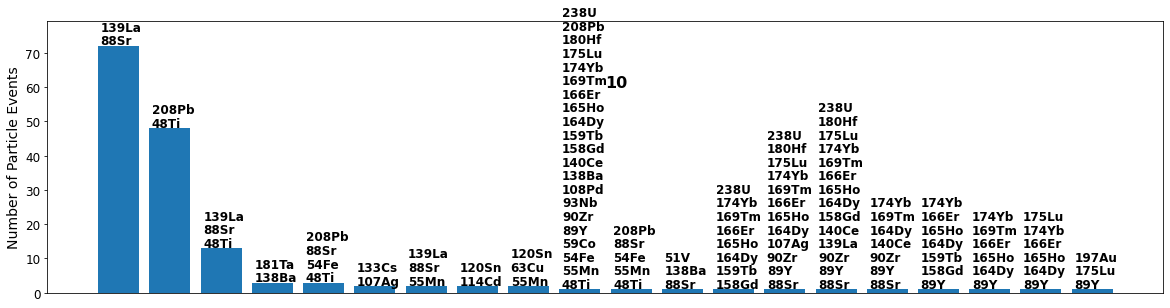

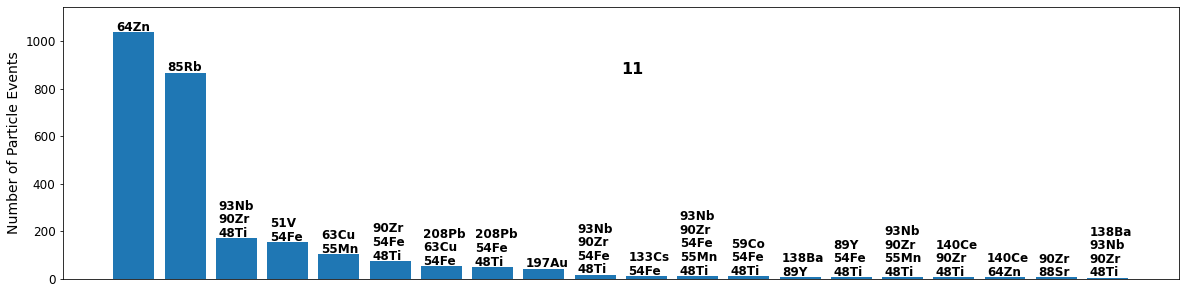

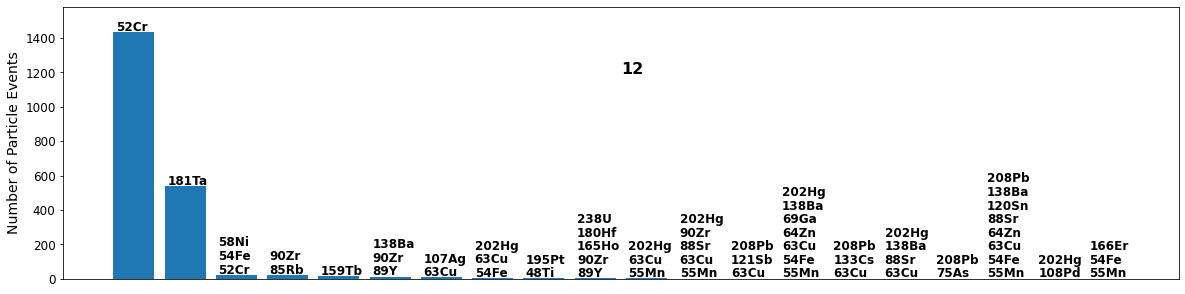

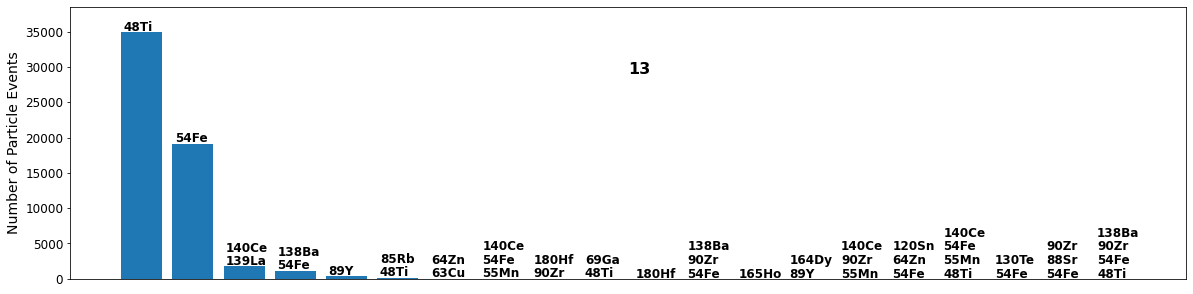

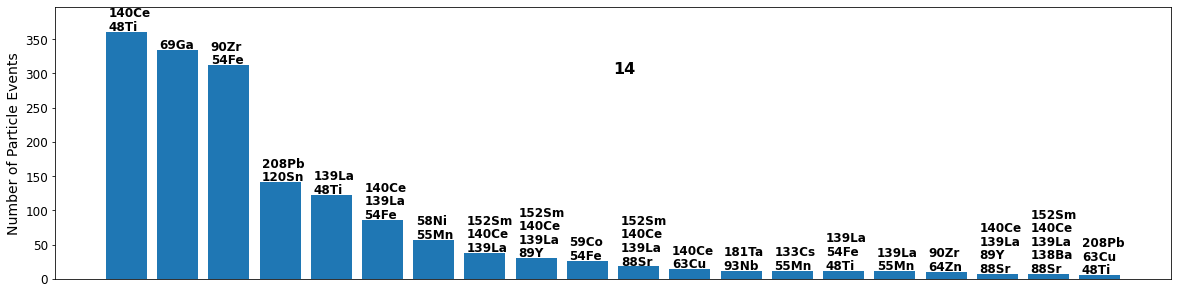

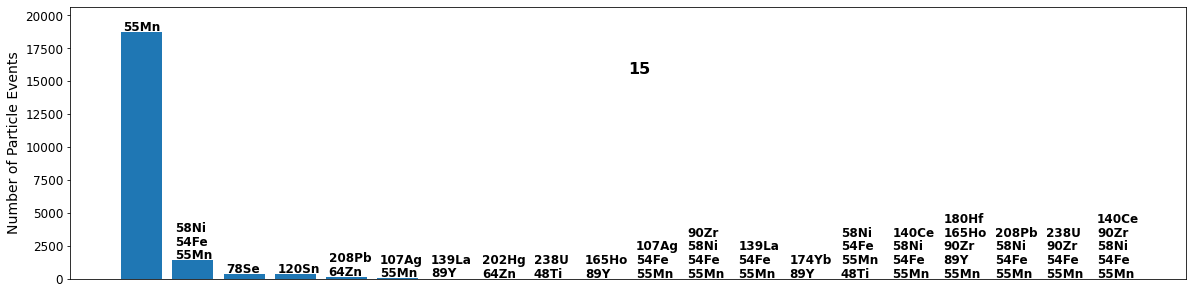

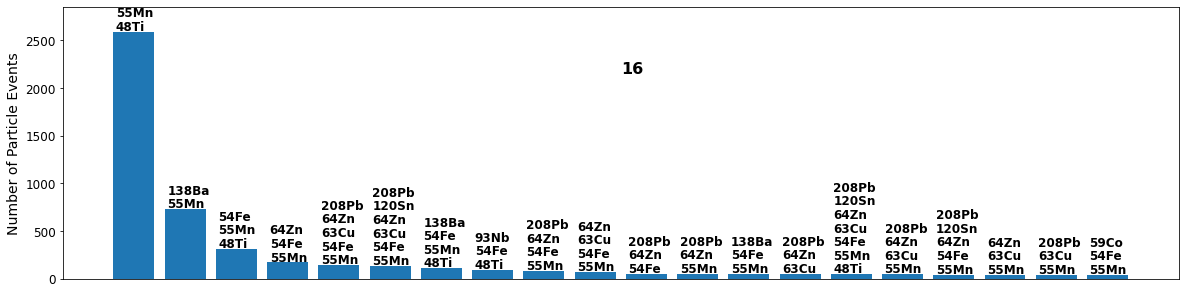

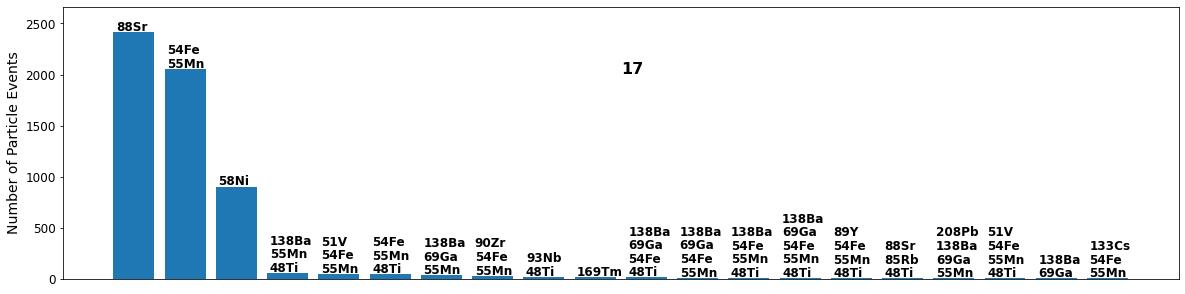

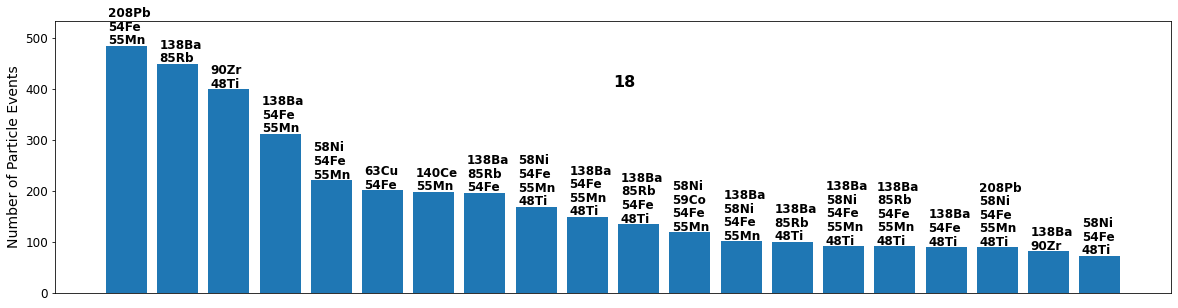

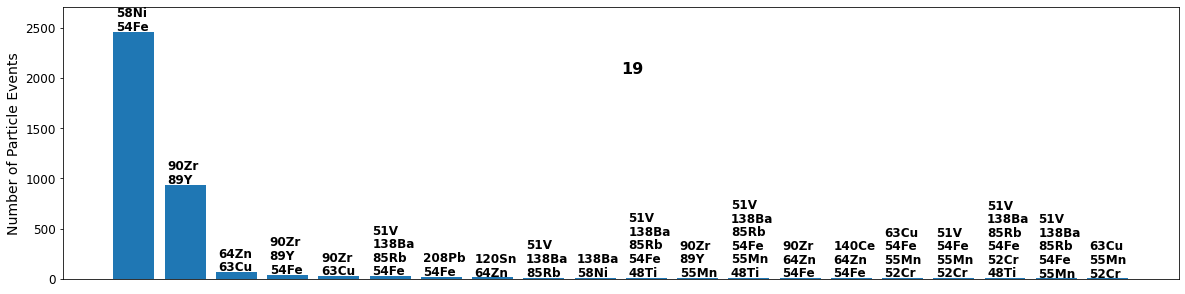

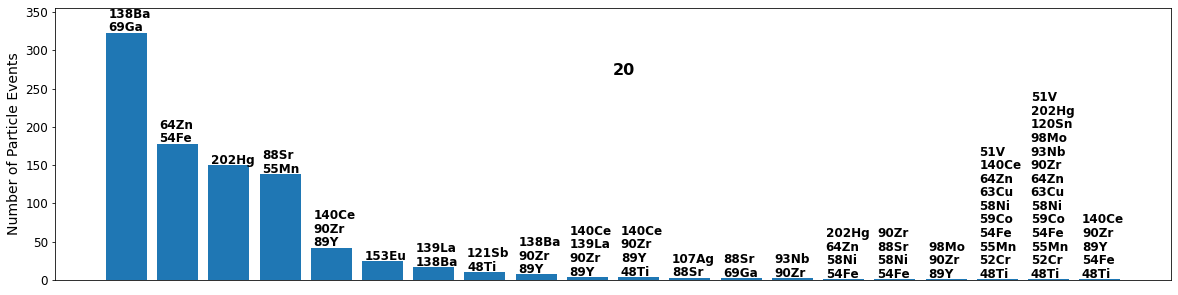

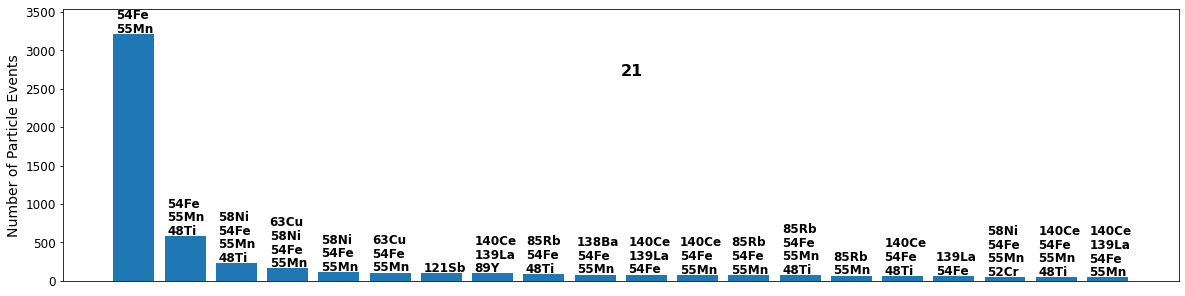

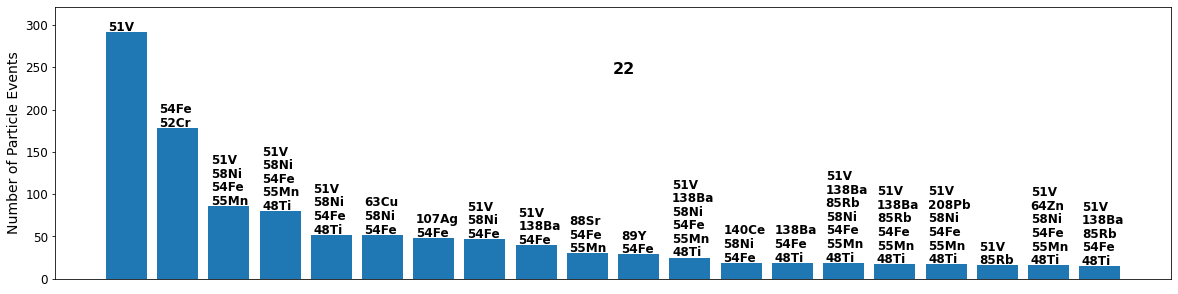

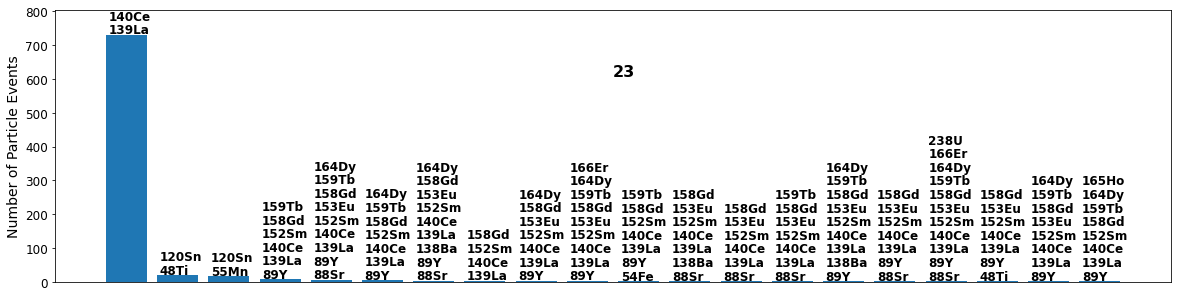

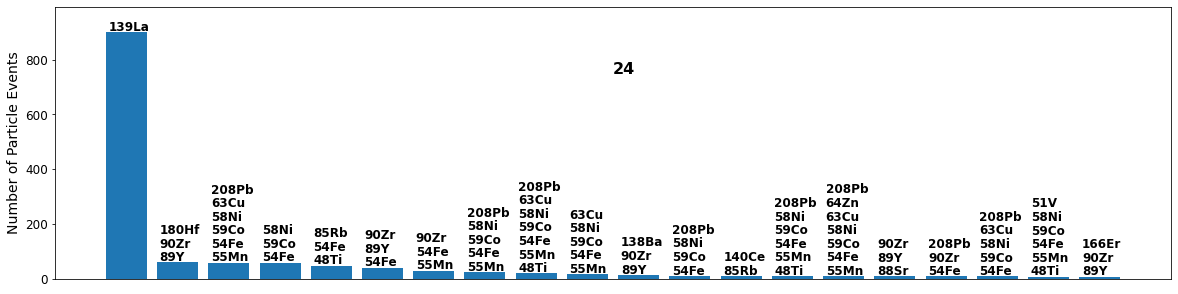

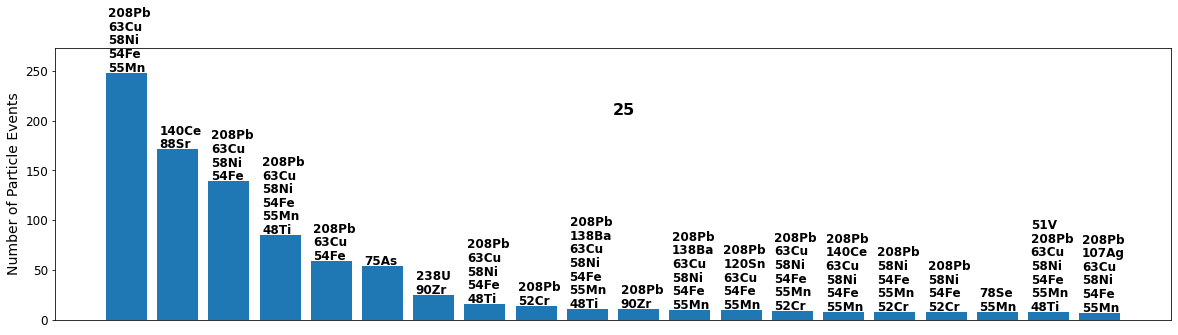

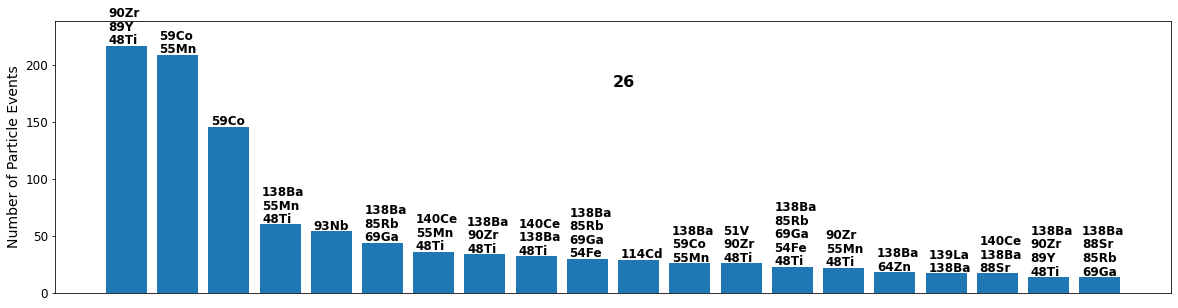

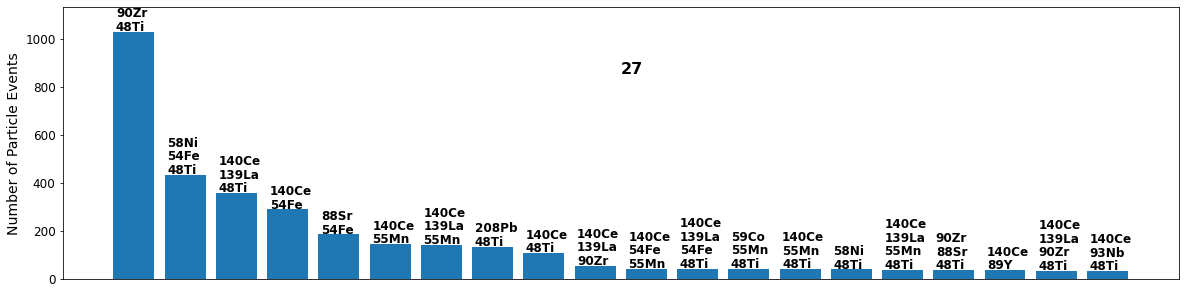

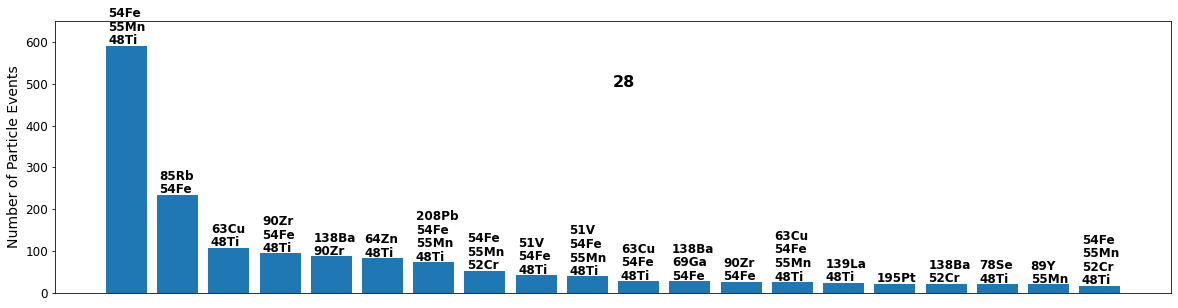

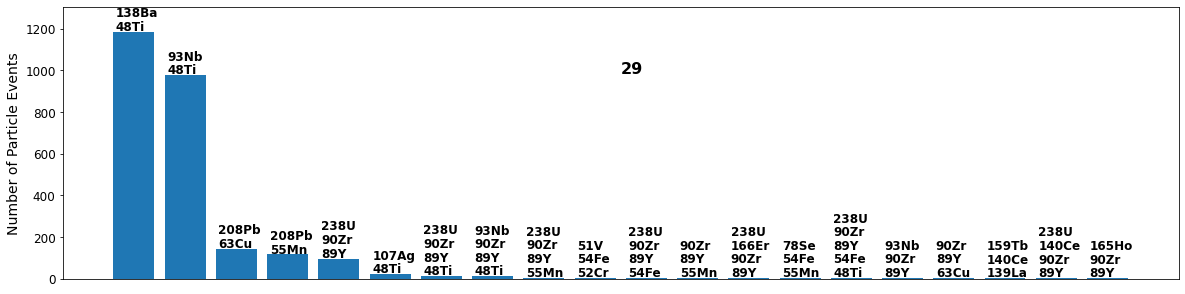

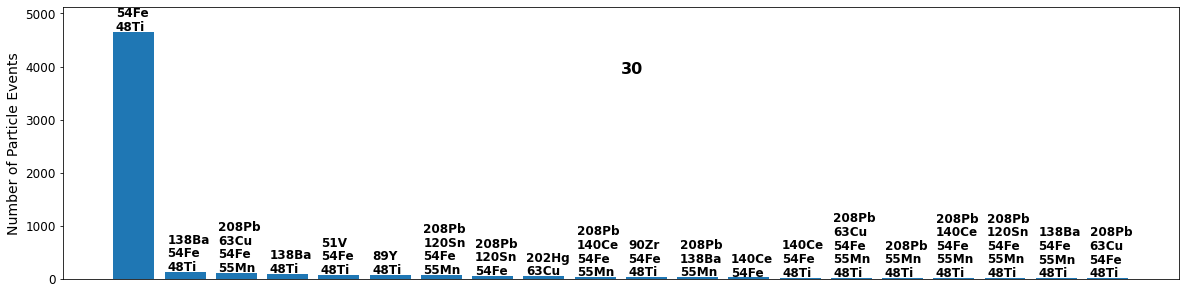

In [22]:
for j in np.arange(0,30,1):
    df = SourceDF[clustersdata[4]['clusters'] == j]

    #fig = plt.figure(figsize = (50,30), dpi = 200)
    aggregate= aggregate_particles(df.iloc[:,:-3])[0:20]
    y = aggregate['Value'].values
    ylabels = []
    for i in aggregate.index:
        ylabels.append(i.split('+'))
    ylabels1 = []
    for i in ylabels:
        ylabels1.append(np.array(i).reshape(len(i),1))
    width = 0.75
    ind = np.arange(len(y))
    fig, ax = plt.subplots(figsize = (20,5))
    ax.bar(ind, aggregate['Value'])
    ax.text(0.5, 0.8, str(j + 1), transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')
    ax.set_xticks([])
    yceiling = aggregate['Value'][0]*1.10
    ax.set_ylim(0, yceiling)
    ax.set_ylabel('Number of Particle Events', fontsize = 14)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 12)

    for i, v in enumerate(y):
        for j in range(0,len(ylabels1[i])):
            ax.text(i - .35, v + yceiling/200 + j*yceiling/20, str(str(str(ylabels1[i][j]).replace("'", '')).replace("[", '')).replace("]", ''), fontsize= 12, fontweight='bold')